## Hourly Range Trading

### Thesis 

Look at hourly candles for the 24hrs of the trading day to find out lowest volume hours that are in market hours, i.e. ranging markets in low spread conditions. this would be an ideal timeframe for implementing a scalping algorithm which benefits on these sideways conditions.

In [209]:
"""
Symbol: EURGBP
Start                     2024-04-01 00:10:00
End                       2024-05-31 23:00:00
Duration                     60 days 22:50:00
Exposure Time [%]                    8.400714
Equity Final [$]                      10045.9
Equity Peak [$]                       10045.9
Return [%]                              0.459
Buy & Hold Return [%]               -0.340606
Return (Ann.) [%]                    2.643662
Volatility (Ann.) [%]                0.455231
Sharpe Ratio                         5.807292
Sortino Ratio                       16.158102
Calmar Ratio                          20.2563
Max. Drawdown [%]                   -0.130511
Avg. Drawdown [%]                   -0.011167
Max. Drawdown Duration       17 days 23:05:00
Avg. Drawdown Duration        0 days 09:42:00
# Trades                                  178
Win Rate [%]                        41.573034
Best Trade [%]                       0.052921
Worst Trade [%]                     -0.018615
Avg. Trade [%]                       0.003017
Max. Trade Duration           0 days 03:41:00
Avg. Trade Duration           0 days 00:31:00

"""

'\nSymbol: EURGBP\nStart                     2024-04-01 00:10:00\nEnd                       2024-05-31 23:00:00\nDuration                     60 days 22:50:00\nExposure Time [%]                    8.400714\nEquity Final [$]                      10045.9\nEquity Peak [$]                       10045.9\nReturn [%]                              0.459\nBuy & Hold Return [%]               -0.340606\nReturn (Ann.) [%]                    2.643662\nVolatility (Ann.) [%]                0.455231\nSharpe Ratio                         5.807292\nSortino Ratio                       16.158102\nCalmar Ratio                          20.2563\nMax. Drawdown [%]                   -0.130511\nAvg. Drawdown [%]                   -0.011167\nMax. Drawdown Duration       17 days 23:05:00\nAvg. Drawdown Duration        0 days 09:42:00\n# Trades                                  178\nWin Rate [%]                        41.573034\nBest Trade [%]                       0.052921\nWorst Trade [%]                     -0.01

In [215]:
import MetaTrader5 as mt5
import pandas as pd
from backtesting import Backtest, Strategy
import ta
from datetime import datetime
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
# Initialize MetaTrader 5
mt5.initialize()

# Settings
symbols = 'EURGBP'
timeframe = mt5.TIMEFRAME_H1
start_date = datetime(2024, 1, 1)
end_time = datetime.now()


# Function to get data from MetaTrader 5
def get_data(symbol, timeframe, start_date, end_time):
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_time)
    df = pd.DataFrame(rates)
    df = df[['time', 'open', 'high', 'low', 'close']]
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def calculate_range(symbols, timeframe, start_date, end_time):
    data = get_data(symbols, timeframe, start_date, end_time)
    data['range'] = data['high'] - data['low']
    return data

def generate_signal(data):
    # Calculate Bollinger Bands
    data['Upper_BB'] = ta.volatility.bollinger_hband(data['close'], window=20)
    data['Lower_BB'] = ta.volatility.bollinger_lband(data['close'], window=20)
    data['Signals'] = 0
    
    for i in range(1, len(data)):
        # Long signal: when close price is below the lower Bollinger Band
        if (data['close'].iloc[i] < data['Lower_BB'].iloc[i]) and (data['close'].iloc[i-1] >= data['Lower_BB'].iloc[i-1]):
            data.at[data.index[i], 'Signals'] = 1
        # Short signal: when close price is above the upper Bollinger Band
        elif (data['close'].iloc[i] > data['Upper_BB'].iloc[i]) and (data['close'].iloc[i-1] <= data['Upper_BB'].iloc[i-1]):
            data.at[data.index[i], 'Signals'] = -1
        else:
            data.at[data.index[i], 'Signals'] = 0
        
    return data

def SIGNAL(data):
    return data['Signals']


data = calculate_range(symbols, timeframe, start_date, end_time)

data_5min = calculate_range(symbols, mt5.TIMEFRAME_M1, datetime(2024, 4, 1), datetime(2024, 6, 6))
data_5min['hour'] = data_5min.index.hour

data_gen_signal = generate_signal(data_5min)

Displaying a boxplot to show the distribution of the range of the hourly candles, for further dissection 

<Figure size 1200x1600 with 0 Axes>

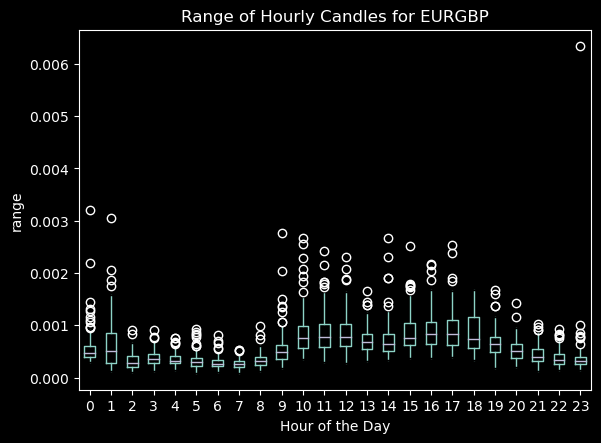

In [216]:

# Extract the hour from the index and group by hour
data['hour'] = data.index.hour

# Create a boxplot
plt.figure(figsize=(12, 16))
data.boxplot(column='range', by='hour', grid=False)
plt.title(f'Range of Hourly Candles for {symbols}')
plt.suptitle('')  # Suppress the automatic 'Boxplot grouped by hour' title
plt.xlabel('Hour of the Day')
plt.ylabel('range')
plt.show()


In [217]:
class hourlyrange(Strategy):
    initsize = 100000.0
    mysize = initsize
    in_position = False
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL, self.data.df, plot= True)
        
    def next(self):
        super().next()
        pip_value = 0.0001
        
        if not self.in_position and self.data.index[-1].hour == 7:
            if self.signal1[-1] == 1:
                sl1 = self.data.Close[-1] - (1.5 * pip_value)
                tp1 = self.data.Close[-1] + (4.5 * pip_value)
                self.buy(sl=sl1, tp=tp1, size=self.mysize)
                self.in_position = True
                
            elif self.signal1[-1] == -1:
                sl1 = self.data.Close[-1] + (1.5 * pip_value)
                tp1 = self.data.Close[-1] - (4.5 * pip_value)
                self.sell(sl=sl1, tp=tp1, size=self.mysize)
                self.in_position = True
        
        # Check if position is closed
        if self.in_position:
            if self.position:
                self.in_position = False


In [218]:
data_gen_signal.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)

# Conduct backtest
bt = Backtest(data_gen_signal, hourlyrange, cash=10000, exclusive_orders=True, margin=1/100)

# Outputs
output = bt.run()
print(f"Symbol: {symbols}")
print(output)
print('-' * 50)

Symbol: EURGBP
Start                     2024-04-01 00:10:00
End                       2024-06-05 23:00:00
Duration                     65 days 22:50:00
Exposure Time [%]                    8.372858
Equity Final [$]                      10532.0
Equity Peak [$]                       10532.0
Return [%]                               5.32
Buy & Hold Return [%]               -0.506812
Return (Ann.) [%]                   31.827717
Volatility (Ann.) [%]                 5.78962
Sharpe Ratio                         5.497376
Sortino Ratio                       19.972382
Calmar Ratio                        25.207066
Max. Drawdown [%]                   -1.262651
Avg. Drawdown [%]                   -0.109135
Max. Drawdown Duration       17 days 23:05:00
Avg. Drawdown Duration        0 days 09:15:00
# Trades                                  190
Win Rate [%]                        41.052632
Best Trade [%]                       0.052921
Worst Trade [%]                     -0.018615
Avg. Trade [%]     

EURGBP shows a sharpe ratio of 5.18 over 2 months of data, although this show that it is overfitted, however it shows promising returns.